In [1]:
pip install sionna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 9.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 79.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 76.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 27.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 83.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, bu

In [2]:
import yaml
from sionna.rt import *
import sionna.rt.scene as builtin_scenes
import mitsuba as mi
import torch
import random
from typing import Callable, Tuple, Optional, List
import numpy as np
import math
import matplotlib.pyplot as plt
import io
from PIL import Image
import tqdm
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd

In [9]:
# Load YAML config
with open("/kaggle/input/sionna/config.yaml", "r") as f:
    cfg = yaml.safe_load(f)
    

In [11]:
# Initialize scene
if cfg['scene']['built_in']!='none':
    scene = load_scene(getattr(builtin_scenes, cfg['scene']['name']))
else:
    file_path="/kaggle/input/sionna-yml/"+cfg['scene']['name']
    scene=load_scene(file_path)

scene.tx_array = PlanarArray(**cfg['scene']['transmitter_array'])
scene.rx_array = PlanarArray(**cfg['scene']['receiver_array'])

tx = Transmitter(**cfg['scene']['transmitter'])
rx = Receiver(**cfg['scene']['receiver'])
scene.add(tx)
scene.add(rx)
tx.look_at(rx)

camera = Camera(**cfg['scene']['camera'])


In [28]:
num_rows=cfg['scene']['transmitter_array']['num_rows']
num_cols=cfg['scene']['transmitter_array']['num_cols']
v_spacing=cfg['scene']['transmitter_array']['vertical_spacing']
h_spacing=cfg['scene']['transmitter_array']['horizontal_spacing']

In [12]:
def compute_precoding_vector_torch(rows, cols, v_space, h_space, theta_deg, phi_deg):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    theta = torch.deg2rad(theta_deg)  # shape: [N]
    phi = torch.deg2rad(phi_deg)      # shape: [N]

    row_indices = torch.arange(rows, dtype=torch.float32, device=device)  # [R]
    col_indices = torch.arange(cols, dtype=torch.float32, device=device)  # [C]

    # [N, R], [N, C]
    phase_row = 2 * math.pi * v_space * torch.sin(theta[:, None]) * row_indices[None, :]
    phase_col = 2 * math.pi * h_space * torch.sin(phi[:, None]) * col_indices[None, :]

    # [N, R], [N, C]
    steer_row = torch.exp(1j * phase_row)
    steer_col = torch.exp(1j * phase_col)

    # [N, R, C]
    steering_matrix = steer_row[:, :, None] * steer_col[:, None, :]

    # [N, R*C]
    precoding_vec = steering_matrix.reshape(steering_matrix.shape[0], -1)

    # Normalize each vector (across dim 1)
    precoding_vec = precoding_vec / torch.linalg.norm(precoding_vec, dim=1, keepdim=True)

    return precoding_vec  # shape: [N, R*C]



In [13]:
def compute_rss(theta_deg, phi_deg):
    precoding_vec = compute_precoding_vector_torch(num_rows, num_cols, v_spacing, h_spacing, theta_deg, phi_deg)
    precoding_vec_cpu = precoding_vec.cpu().numpy()

    precoding_vec_real = mi.TensorXf(precoding_vec_cpu.real.astype(np.float32))
    precoding_vec_imag = mi.TensorXf(precoding_vec_cpu.imag.astype(np.float32))

    precoding_vec = zip(precoding_vec_real,precoding_vec_imag)
    rss = []
    for i in precoding_vec:
        coverage_map = rm_solver(
            scene=scene,
            cell_size=[1, 1],
            samples_per_tx=int(1e8),
            max_depth=7,
            precoding_vec=i,
            los=True,
            specular_reflection=True,
            diffuse_reflection=True,
            refraction=False
        )
    
        rss_tensor = coverage_map.rss.numpy()
        cell_centers = coverage_map.cell_centers.numpy()
        _, num_cells_y, num_cells_x = rss_tensor.shape
    
        flat_centers = cell_centers.reshape(-1, 3)
        rx_pos = np.array(rx.position).reshape(1, 3)
        distances = np.linalg.norm(flat_centers - rx_pos, axis=1)
        nearest_index = np.argmin(distances)
    
        y_idx = nearest_index // num_cells_x
        x_idx = nearest_index % num_cells_x
        rss_linear = rss_tensor[0, y_idx, x_idx]
        #rss.append(torch.tensor(rss_linear))
        rss.append(10 * torch.log10(torch.tensor(rss_linear)) if rss_linear > 0 else torch.tensor(-200))
    return torch.stack(rss)


In [17]:
class PSOBeamSearcherTorch:
    def __init__(
        self,
        fitness_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        population_size: int = 30,
        max_generations: int = 50,
        w: float = 0.5,
        c1: float = 1.5,
        c2: float = 1.5,
        search_resolution: float = 5.0,
        search_window: float = 30.0,
        stagnant_limit: int = 4,
        seed_particle: Optional[Tuple[float, float]] = None,
        angle_unit: str = "degree"
    ):
        self.fitness_fn = fitness_fn
        self.pop_size = population_size
        self.max_gen = max_generations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.search_resolution = search_resolution
        self.search_window = search_window
        self.stagnant_limit = stagnant_limit
        self.angle_unit = angle_unit.lower()
        self.seed_particle = seed_particle

        self.factor = math.pi / 180 if self.angle_unit == "degree" else 1.0
        self.res = self.search_resolution * self.factor
        self.window = self.search_window * self.factor

    def _initialize_particles(self, device):
        # Generate candidates in ±30° window around seed
        if self.seed_particle is None:
            raise ValueError("seed_particle must be provided for local search.")

        seed_theta, seed_phi = self.seed_particle
        seed_theta *= self.factor
        seed_phi *= self.factor

        theta_range = torch.arange(
            seed_theta - self.window,
            seed_theta + self.window + self.res,
            self.res, device=device
        ).clamp(-math.pi / 2, math.pi / 2)  # theta ∈ [0, π/2] ##

        phi_range = torch.arange(
            seed_phi - self.window,
            seed_phi + self.window + self.res,
            self.res, device=device
        ) % (2 * math.pi)  # phi ∈ [0, 2π]

        theta = theta_range[torch.randint(0, len(theta_range), (self.pop_size,))]
        phi = phi_range[torch.randint(0, len(phi_range), (self.pop_size,))]

        return theta, phi

    def _round_to_res(self, angles: torch.Tensor) -> torch.Tensor:
        return torch.round(angles / self.res) * self.res

    def search(self):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.seed_particle)
        theta, phi = self._initialize_particles(device)
        v_theta = torch.zeros_like(theta)
        v_phi = torch.zeros_like(phi)

        fitness = self.fitness_fn(theta, phi).to(device)
        pbest_theta, pbest_phi, pbest_rss = theta.clone(), phi.clone(), fitness.clone()

        best_idx = torch.argmax(fitness)
        gbest_theta = pbest_theta[best_idx].clone()
        gbest_phi = pbest_phi[best_idx].clone()
        gbest_rss = pbest_rss[best_idx].clone()

        stagnant_counter = 0

        for _ in range(self.max_gen):
            r1, r2 = torch.rand(self.pop_size, device=device), torch.rand(self.pop_size, device=device)

            v_theta = self.w * v_theta + self.c1 * r1 * (pbest_theta - theta) + self.c2 * r2 * (gbest_theta - theta)
            v_phi = self.w * v_phi + self.c1 * r1 * (pbest_phi - phi) + self.c2 * r2 * (gbest_phi - phi)

            theta = torch.clamp(theta + v_theta, 0, math.pi / 2)
            phi = (phi + v_phi) % (2 * math.pi)

            theta = self._round_to_res(theta)
            phi = self._round_to_res(phi)

            fitness = self.fitness_fn(theta, phi).to(device)

            better = fitness > pbest_rss
            pbest_theta = torch.where(better, theta, pbest_theta)
            pbest_phi = torch.where(better, phi, pbest_phi)
            pbest_rss = torch.where(better, fitness, pbest_rss)

            best_idx = torch.argmax(pbest_rss)
            if pbest_rss[best_idx] > gbest_rss:
                gbest_theta = pbest_theta[best_idx].clone()
                gbest_phi = pbest_phi[best_idx].clone()
                gbest_rss = pbest_rss[best_idx].clone()
                self.seed_particle = (gbest_theta.item(), gbest_phi.item())
                stagnant_counter = 0
            else:
                stagnant_counter += 1
                if stagnant_counter >= self.stagnant_limit and gbest_rss.item() > -58:
                    break

        if self.angle_unit == "degree":
            return torch.rad2deg(gbest_theta), torch.rad2deg(gbest_phi), gbest_rss
        else:
            return gbest_theta, gbest_phi, gbest_rss

In [16]:
path_solver = PathSolver()
def compute_rss_from_path_solver(theta, phi):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    paths = path_solver(scene, max_depth=5, los=True, specular_reflection=True, diffuse_reflection=False, refraction=True)
    
    # --- 1. Extract CIR from paths ---
    cir = paths.cir(out_type='torch')[0].to(torch.complex64).to(device)

    # --- 2. Compute Precoding Vector ---
    w = compute_precoding_vector_torch(num_rows, num_cols, 0.5, 0.5, theta, phi).T  # Shape: [Rows * Columns, N]
    w = w.to(torch.complex64).to(device)

    # --- 3. Channel Matrix (sum over paths) ---
    H = cir.sum(dim=-1).sum(dim=-1)
    H = H.reshape(-1, H.shape[2] * H.shape[3])

    # --- 4. Beamforming: y = H @ w ---
    y = torch.matmul(H, w)  # Shape: [Rx, N]

    # --- 5. RSS = sum |y|^2 across Rx antennas ---
    rss = torch.sum(torch.abs(y)**2, dim=0)  # Shape: [N]

    # --- 6. Convert to dB ---
    rss_db = 10 * torch.log10(rss) +13.71

    return rss

In [22]:
pso = PSOBeamSearcherTorch(
    fitness_fn=compute_rss_from_path_solver,
    population_size=50,
    max_generations=30,  # you can adjust this for speed vs accuracy
    w=0.5,
    c1=1.5,
    c2=1.5,
    stagnant_limit = 20,
    seed_particle=(0, 0),
    angle_unit='degree'
)

In [23]:
compute_rss_from_path_solver(torch.tensor([35,90]),torch.tensor([50,125]))

tensor([1.1430e-11, 1.4683e-11])

In [24]:
class GABeamSearcherTorch:
    def __init__(
        self,
        fitness_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        population_size: int = 30,
        max_generations: int = 50,
        mutation_rate: float = 0.2,
        crossover_rate: float = 0.7,
        angle_bounds: Tuple[Tuple[float, float], Tuple[float, float]] = ((0, 90), (0, 360)),
        seed_particle: Optional[Tuple[float, float]] = None,
        resolution: float = 5.0,
        search_limit: float = 30.0,
        stagnant_limit: int = 4,
        elite_count: int = 3,
        angle_unit: str = "degree",
        min_std_threshold: float = 0.05
    ):
        self.fitness_fn = fitness_fn
        self.pop_size = population_size
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.angle_bounds = angle_bounds
        self.seed_particle = seed_particle
        self.resolution = resolution
        self.search_limit = search_limit
        self.stagnant_limit = stagnant_limit
        self.elite_count = elite_count
        self.angle_unit = angle_unit.lower()
        self.min_std_threshold = min_std_threshold
        self.angle_history = []
        self.convergence_rss = []

        self.factor = math.pi / 180 if self.angle_unit == "degree" else 1.0
        self.theta_bounds = tuple(f * self.factor for f in self.angle_bounds[0])
        self.phi_bounds = tuple(f * self.factor for f in self.angle_bounds[1])
        self.search_limit *= self.factor
        if self.seed_particle:
            self.seed_particle = (seed_particle[0] * self.factor, seed_particle[1] * self.factor)

        self.elite_buffer: List[Tuple[float, float]] = []

    def _sample_population(self, center_theta, center_phi, device):
        theta_offset = (torch.rand(self.pop_size, device=device) * 2 - 1) * self.search_limit
        phi_offset = (torch.rand(self.pop_size, device=device) * 2 - 1) * self.search_limit

        theta = center_theta + theta_offset
        phi = center_phi + phi_offset

        theta = torch.remainder(theta, math.pi)
        phi = torch.remainder(phi, 2 * math.pi)

        resolution = self.resolution * self.factor
        theta = torch.round(theta / resolution) * resolution
        phi = torch.round(phi / resolution) * resolution

        return theta, phi

    def _crossover(self, t1, p1, t2, p2):
        mask = torch.rand_like(t1) < 0.5
        return torch.where(mask, t1, t2), torch.where(mask, p1, p2)

    def _mutate(self, theta, phi):
        noise_t = (torch.rand_like(theta) - 0.5) * 2 * self.resolution * self.factor
        noise_p = (torch.rand_like(phi) - 0.5) * 2 * self.resolution * self.factor
        theta = torch.remainder(theta + noise_t, math.pi)
        phi = torch.remainder(phi + noise_p, 2 * math.pi)
        return theta, phi

    def search(self) -> Tuple[float, float, float]:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if self.seed_particle:
            theta, phi = self._sample_population(self.seed_particle[0], self.seed_particle[1], device)
        else:
            theta = torch.rand(self.pop_size, device=device) * math.pi
            phi = torch.rand(self.pop_size, device=device) * 2 * math.pi

        self.angle_history.extend([
            (math.degrees(t.item()), math.degrees(p.item())) for t, p in zip(theta, phi)
        ])

        fitness = self.fitness_fn(theta, phi)
        best_idx = torch.argmax(fitness)
        best_theta = theta[best_idx].clone()
        best_phi = phi[best_idx].clone()
        best_rss = fitness[best_idx].clone()
        stagnant_counter = 0

        for gen in range(self.max_generations):
            self.elite_buffer.append((best_theta.item(), best_phi.item()))
            if len(self.elite_buffer) > self.elite_count:
                self.elite_buffer.pop(0)

            theta, phi = self._sample_population(best_theta, best_phi, device)
            fitness = self.fitness_fn(theta, phi)

            print(f"[GEN {gen:03}] RSS Max: {fitness.max().item():.2f} | Std: {fitness.std().item():.4f}")

            if fitness.std().item() < self.min_std_threshold:
                print(f"[STOP] RSS standard deviation below threshold: {fitness.std().item():.4f}")
                break

            top_k = torch.topk(fitness, k=self.pop_size // 2).indices
            parents_theta = theta[top_k]
            parents_phi = phi[top_k]

            elite_theta = torch.tensor([e[0] for e in self.elite_buffer], device=device)
            elite_phi = torch.tensor([e[1] for e in self.elite_buffer], device=device)

            combined_theta = torch.cat([parents_theta, elite_theta])
            combined_phi = torch.cat([parents_phi, elite_phi])

            new_theta, new_phi = [], []
            for _ in range(self.pop_size):
                i1, i2 = random.sample(range(len(combined_theta)), 2)
                t1, p1 = combined_theta[i1], combined_phi[i1]
                t2, p2 = combined_theta[i2], combined_phi[i2]

                if random.random() < self.crossover_rate:
                    child_theta, child_phi = self._crossover(t1, p1, t2, p2)
                else:
                    child_theta, child_phi = t1.clone(), p1.clone()

                if random.random() < self.mutation_rate or True:  # Always some noise
                    child_theta, child_phi = self._mutate(child_theta.unsqueeze(0), child_phi.unsqueeze(0))
                    child_theta, child_phi = child_theta[0], child_phi[0]

                new_theta.append(child_theta)
                new_phi.append(child_phi)

            theta = torch.stack(new_theta)
            phi = torch.stack(new_phi)
            fitness = self.fitness_fn(theta, phi)
            gen_best_idx = torch.argmax(fitness)

            if fitness[gen_best_idx] > best_rss:
                best_theta = theta[gen_best_idx].clone()
                best_phi = phi[gen_best_idx].clone()
                best_rss = fitness[gen_best_idx].clone()
                self.seed_particle = (best_theta.item(), best_phi.item())
                stagnant_counter = 0
            else:
                stagnant_counter += 1
                if stagnant_counter >= self.stagnant_limit:
                    print(f"[STOP] No improvement for {self.stagnant_limit} generations.")
                    break
                    
        self.convergence_rss.append(best_rss.item())
        resolution = self.resolution * self.factor
        best_theta = torch.round(best_theta / resolution) * resolution
        best_phi = torch.round(best_phi / resolution) * resolution

        if self.angle_unit == "degree":
            return (
                torch.rad2deg(best_theta),
                torch.rad2deg(best_phi),
                best_rss
            )
        else:
            return best_theta, best_phi, best_rss


    def plot_convergence(self):
        if not hasattr(self, "convergence_rss"):
            print("No convergence data found.")
            return
    
        plt.figure(figsize=(8, 4))
        plt.plot(self.convergence_rss, marker="o")
        plt.xlabel("Generation")
        plt.ylabel("Best RSS")
        plt.title("Genetic Algorithm Convergence")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    def plot_angle_heatmap(angle_history, resolution=1.0):
        df = pd.DataFrame(angle_history, columns=["theta_deg", "phi_deg"])
        df["theta_bin"] = (df["theta_deg"] / resolution).round() * resolution
        df["phi_bin"] = (df["phi_deg"] / resolution).round() * resolution
        heatmap = df.groupby(["theta_bin", "phi_bin"]).size().reset_index(name="count")
        fig = px.density_heatmap(
            heatmap,
            x="phi_bin",
            y="theta_bin",
            z="count",
            nbinsx=int(360 / resolution),
            nbinsy=int(90 / resolution),
            color_continuous_scale="Turbo",
            labels={"phi_bin": "Azimuth (°)", "theta_bin": "Elevation (°)", "count": "Hits"},
            title="Angle Exploration Heatmap"
        )
        fig.update_yaxes(autorange="reversed")
        fig.show()


In [25]:
searcher = GABeamSearcherTorch(
    fitness_fn=compute_rss_from_path_solver,
    population_size = 50,
    max_generations = 100,
    mutation_rate = 0.7,
    crossover_rate = 0.5,
    seed_particle=(0, 0),
    search_limit=40,
    angle_bounds=((0, 90), (0, 360)),
    resolution=0.5,
    elite_count=3,#
    stagnant_limit = 20,
    angle_unit='degree'
)

In [30]:
precoding_vec = compute_precoding_vector_torch(num_rows, num_cols, v_spacing, h_spacing, torch.tensor([0]), torch.tensor([0])).cpu().numpy()

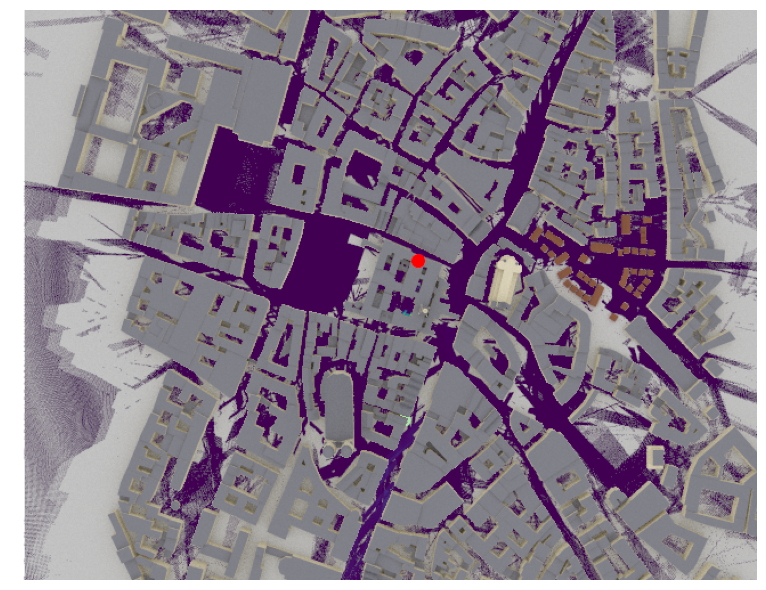

In [38]:
rm_solver=RadioMapSolver()
coverage_map = rm_solver(
    scene=scene,
    cell_size=[0.5, 0.5],
    samples_per_tx=int(1e7),
    max_depth=7,
    precoding_vec=(
        mi.TensorXf(precoding_vec.real.astype(np.float32)),
        mi.TensorXf(precoding_vec.imag.astype(np.float32))
    ),
    los=True,
    specular_reflection=True,
    diffuse_reflection=True,
    refraction=False
)

fig = scene.render(
        camera=camera,
        radio_map=coverage_map,
        rm_metric="rss",
        rm_db_scale=False
    )

In [32]:
rss_start = compute_rss_from_path_solver(torch.tensor([0]),torch.tensor([0])).item()
# paths = path_solver(scene, max_depth = 5)

In [39]:
simulation_summary = []

# simulation_summary.append((0, 0, rss_start, h))
simulation_summary.append((0, 0, rss_start))

# Prepare to store frames
frames = []
buf = io.BytesIO()
fig.savefig(buf, format='png')
buf.seek(0)
frames.append(Image.open(buf))
plt.close(fig)
rm_solver = RadioMapSolver()
# Define receiver movement parameters
num_frames = 42
x_positions = np.linspace(-30, 180, num_frames)

for x in tqdm.tqdm(x_positions):
    # Update receiver position
    rx.position = np.array([-70, x, 1.5])

    theta, phi, rss = pso.search()
    print(rss)

    precoding_vec = compute_precoding_vector_torch(
        rows = num_rows,
        cols= num_cols,
        v_space = v_spacing,
        h_space = h_spacing, 
        theta_deg = theta.reshape(-1), 
        phi_deg = phi.reshape(-1)
    ).cpu().numpy()

    coverage_map = rm_solver(
        scene=scene,
        cell_size=[0.5, 0.5],
        samples_per_tx=int(1e7),
        max_depth=7,
        precoding_vec=(
            mi.TensorXf(precoding_vec.real.astype(np.float32)),
            mi.TensorXf(precoding_vec.imag.astype(np.float32))
        ),
        los=True,
        specular_reflection=True,
        diffuse_reflection=True,
        refraction=False
    )

    # h = path_solver(scene, max_depth=5).cir()[0]  # Just CIR tensor


    # simulation_summary.append((
    #     theta.item(),
    #     phi.item(),
    #     rss.item(),
    #     h
    # ))

    simulation_summary.append((
        theta.item(),
        phi.item(),
        rss.item()
    ))
    
    # Render scene with coverage map
    fig = scene.render(
        camera=camera,
        radio_map=coverage_map,
        rm_metric="rss",
        rm_db_scale=True
    )

    buf = io.BytesIO()

    # Save the figure to a BytesIO object
    fig.savefig(buf, format='png')
    buf.seek(0)
    frames.append(Image.open(buf))
    plt.close(fig)

frames[0].save(
    'coverage_animation.gif',
    save_all=True,
    append_images=frames[1:],
    duration=200,  # duration between frames in milliseconds
    loop=0  # loop indefinitely
)


  0%|          | 0/42 [00:00<?, ?it/s]

(0, 0)
tensor(8.8239e-11)


  2%|▏         | 1/42 [01:07<46:27, 67.99s/it]

(0.0, 5.410520553588867)
tensor(3.4837e-09)


  5%|▍         | 2/42 [02:10<43:21, 65.05s/it]

(0.0, 6.283185005187988)
tensor(2.1536e-08)


  7%|▋         | 3/42 [03:14<41:43, 64.19s/it]

(0.1745329201221466, 6.283185005187988)
tensor(1.9569e-08)


 10%|▉         | 4/42 [04:17<40:20, 63.69s/it]

(0.0, 6.283185005187988)
tensor(1.4075e-08)


 12%|█▏        | 5/42 [05:19<39:05, 63.40s/it]

(0.0, 6.283185005187988)
tensor(1.2332e-08)


 14%|█▍        | 6/42 [06:22<37:49, 63.04s/it]

(0.7853981256484985, 6.283185005187988)
tensor(1.5994e-14)


 17%|█▋        | 7/42 [07:25<36:47, 63.08s/it]

(0.0, 6.283185005187988)
tensor(8.2563e-09)


 19%|█▉        | 8/42 [08:28<35:45, 63.10s/it]

(0.0, 6.283185005187988)
tensor(2.5308e-09)


 21%|██▏       | 9/42 [09:31<34:39, 63.01s/it]

(0.0, 0.5235987901687622)
tensor(6.7328e-11)


 24%|██▍       | 10/42 [10:34<33:38, 63.07s/it]

(0.0872664600610733, 6.283185005187988)
tensor(2.3216e-09)


 26%|██▌       | 11/42 [11:37<32:33, 63.01s/it]

(0.0, 0.0)
tensor(2.0862e-09)


 29%|██▊       | 12/42 [12:39<31:18, 62.61s/it]

(0.0, 0.0)
tensor(1.1485e-10)


 31%|███       | 13/42 [13:53<31:59, 66.18s/it]

(0.0, 2.96705961227417)
tensor(4.1072e-15)


 33%|███▎      | 14/42 [14:57<30:35, 65.54s/it]

(0.0, 1.919862151145935)
tensor(1.1133e-14)


 36%|███▌      | 15/42 [16:00<29:05, 64.66s/it]

(0.0872664600610733, 0.0)
tensor(1.8373e-09)


 38%|███▊      | 16/42 [17:02<27:38, 63.81s/it]

(0.0872664600610733, 0.0)
tensor(3.4870e-11)


 40%|████      | 17/42 [18:04<26:25, 63.41s/it]

(0.2617993950843811, 6.283185005187988)
tensor(2.5220e-10)


 43%|████▎     | 18/42 [19:07<25:17, 63.25s/it]

(0.0872664600610733, 6.283185005187988)
tensor(2.5949e-10)


 45%|████▌     | 19/42 [20:11<24:20, 63.50s/it]

(0.0, 6.283185005187988)
tensor(1.5293e-13)


 48%|████▊     | 20/42 [21:14<23:15, 63.43s/it]

(0.0, 6.283185005187988)
tensor(2.1737e-13)


 50%|█████     | 21/42 [22:17<22:08, 63.28s/it]

(0.0, 6.283185005187988)
tensor(6.5699e-13)


 52%|█████▏    | 22/42 [23:20<20:59, 62.99s/it]

(0.0, 5.759586334228516)
tensor(1.0436e-12)


 55%|█████▍    | 23/42 [24:24<20:03, 63.33s/it]

(0.0, 5.148721218109131)
tensor(1.7956e-11)


 57%|█████▋    | 24/42 [25:27<18:58, 63.26s/it]

(0.1745329201221466, 3.752457857131958)
tensor(3.5773e-10)


/usr/local/lib/python3.11/dist-packages/drjit/ast.py:838: RuntimeWarning:

The AST-transforming decorator @drjit.syntax was called more than 1000 times by your program. Since transforming and recompiling Python code is a relatively expensive operation, it should not be used within loops or subroutines. Please move the function to be transformed to the top program level and decorate it there.

 60%|█████▉    | 25/42 [26:30<17:57, 63.36s/it]

(0.1745329201221466, 0.0)
tensor(1.0135e-11)


 62%|██████▏   | 26/42 [27:34<16:54, 63.42s/it]

(0.0, 5.585053443908691)
tensor(4.5273e-11)


 64%|██████▍   | 27/42 [28:38<15:54, 63.62s/it]

(0.1745329201221466, 0.0)
tensor(8.7313e-12)


 67%|██████▋   | 28/42 [29:40<14:43, 63.10s/it]

(0.1745329201221466, 0.0)
tensor(2.1543e-12)


 69%|██████▉   | 29/42 [30:44<13:45, 63.52s/it]

(0.0, 4.363323211669922)
tensor(0.)


 71%|███████▏  | 30/42 [31:46<12:37, 63.09s/it]

(0.0, 4.363323211669922)
tensor(4.1255e-11)


 74%|███████▍  | 31/42 [32:51<11:39, 63.63s/it]

(0.0, 1.3089969158172607)
tensor(3.5652e-11)


 76%|███████▌  | 32/42 [33:56<10:38, 63.89s/it]

(0.0, 2.7052602767944336)
tensor(0.)


 79%|███████▊  | 33/42 [34:58<09:29, 63.29s/it]

(0.0, 2.7052602767944336)
tensor(0.)


 81%|████████  | 34/42 [35:59<08:20, 62.62s/it]

(0.0, 2.7052602767944336)
tensor(4.2812e-12)


 83%|████████▎ | 35/42 [37:07<07:29, 64.22s/it]

(0.0, 4.974188327789307)
tensor(1.3517e-10)


 86%|████████▌ | 36/42 [38:10<06:22, 63.83s/it]

(0.0, 4.014256954193115)
tensor(4.2199e-11)


 88%|████████▊ | 37/42 [39:12<05:17, 63.45s/it]

(0.0, 5.6723198890686035)
tensor(2.2615e-12)


 90%|█████████ | 38/42 [40:15<04:12, 63.16s/it]

(0.0, 6.283185005187988)
tensor(0.)


 93%|█████████▎| 39/42 [41:16<03:07, 62.56s/it]

(0.0, 6.283185005187988)
tensor(0.)


 95%|█████████▌| 40/42 [42:17<02:04, 62.22s/it]

(0.0, 6.283185005187988)
tensor(1.2950e-12)


 98%|█████████▊| 41/42 [43:21<01:02, 62.67s/it]

(0.0, 3.665191411972046)
tensor(0.)


100%|██████████| 42/42 [44:22<00:00, 63.40s/it]


In [41]:
import torch
import plotly.graph_objs as go

def plot_simulation_summary(simulation_summary):
    # Extract values from tuples and move to CPU
    thetas = [theta for theta, phi, rss in simulation_summary]
    phis = [phi for theta, phi, rss in simulation_summary]
    rss_vals = [rss for theta, phi, rss in simulation_summary]

    # Create 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=thetas,
        y=phis,
        z=rss_vals,
        mode='markers+lines',
        marker=dict(
            size=6,
            color=rss_vals,     # Color by RSS value
            colorscale='Viridis',
            colorbar=dict(title='RSS (dB)')
        ),
        line=dict(
            color='gray',
            width=2
        )
    )])

    # Axis labels and layout
    fig.update_layout(
        title='Beamforming Simulation Search Path',
        scene=dict(
            xaxis_title='Theta (°)',
            yaxis_title='Phi (°)',
            zaxis_title='RSS (dB)'
        ),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show(renderer = "iframe")

In [42]:
plot_simulation_summary(simulation_summary)

In [43]:
import json
import torch
import numpy as np

def to_serializable(obj):
    """
    Recursively convert torch tensors, numpy arrays, and other non-serializable
    objects to Python native types (float, list, dict).
    """
    if isinstance(obj, torch.Tensor):
        return obj.detach().cpu().numpy().tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (float, int, str, type(None))):
        return obj
    elif isinstance(obj, (list, tuple)):
        return [to_serializable(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    else:
        return str(obj)  # fallback: convert unknown types to string

def convert_simulation_summary_to_serializable(simulation_summary):
    """
    Converts simulation_summary containing tensors and other complex types into
    a fully JSON-serializable list of dictionaries.
    """
    serializable_summary = []

    for entry in simulation_summary:
        if isinstance(entry, (list, tuple)) and len(entry) == 4:
            theta, phi, rss, cir = entry
            serializable_summary.append({
                "theta": to_serializable(theta),
                "phi": to_serializable(phi),
                "rss": to_serializable(rss),
                "cir": to_serializable(cir)
            })
        else:
            # fallback for malformed entries
            serializable_summary.append(to_serializable(entry))

    return serializable_summary



serializable_data = convert_simulation_summary_to_serializable(simulation_summary)

with open("simulation_summary.json", "w") as f:
    json.dump(serializable_data, f, indent=4)
